In [175]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import math

In [177]:
# impot data
eps = 1
N = 2500
num_bins_list = [int(1E2), int(1E3), int(1E4), int(1E5), int(1E6)]
left_coin = num_bins_list[0]
right_coin = num_bins_list[-1]

success_list = []
coins_list = []
errors_list = []
label_list = []

with open(f'results/BayeSS/N_{N}/eps_{eps}/bins_{left_coin}_{right_coin}/success.pkl', 'rb') as f:
    success = pickle.load(f)
with open(f'results/BayeSS/N_{N}/eps_{eps}/bins_{left_coin}_{right_coin}/coins.pkl', 'rb') as f:
    coins = pickle.load(f)
with open(f'results/BayeSS/N_{N}/eps_{eps}/bins_{left_coin}_{right_coin}/errors.pkl', 'rb') as f:
    errors = pickle.load(f)

success_list.append(success)
coins_list.append(coins)
errors_list.append(errors)
label_list.append('DpBayeSS')

with open(f'results/noisy_binary_search/N_{N}/eps_{eps}/bins_{left_coin}_{right_coin}/success.pkl', 'rb') as f:
    success = pickle.load(f)
with open(f'results/noisy_binary_search/N_{N}/eps_{eps}/bins_{left_coin}_{right_coin}/coins.pkl', 'rb') as f:
    coins = pickle.load(f)
with open(f'results/noisy_binary_search/N_{N}/eps_{eps}/bins_{left_coin}_{right_coin}/errors.pkl', 'rb') as f:
    errors = pickle.load(f)
    
success_list.append(success)
coins_list.append(coins)
errors_list.append(errors)
label_list.append('DpNaiveNBS')

def upload_data(N: int, B: int):
    folder_name = f"data/N_{N}/B_{B}"
    output = {}
    # import data
    with open(f'{folder_name}/data.pkl', 'rb') as f:
        data = pickle.load(f)
    output["data"] = data

    # import median
    with open(f'{folder_name}/median.pkl', 'rb') as f:
        median = pickle.load(f)
    output["median"] = median

    # import median quantile
    with open(f'{folder_name}/median_quantile.pkl', 'rb') as f:
        median_quantile = pickle.load(f)
    output["median_quantile"] = median_quantile

    # import cdf
    with open(f'{folder_name}/cdf.pkl', 'rb') as f:
        cf_dict = pickle.load(f)
    output["cf_dict"] = cf_dict

    return output

In [178]:
colors = ['b', 'r']
markers = ["-", "-"]

# Success probability vs number of bins

In [179]:
def get_binomial_std(p, n):
    return np.sqrt(p * (1 - p) / n)

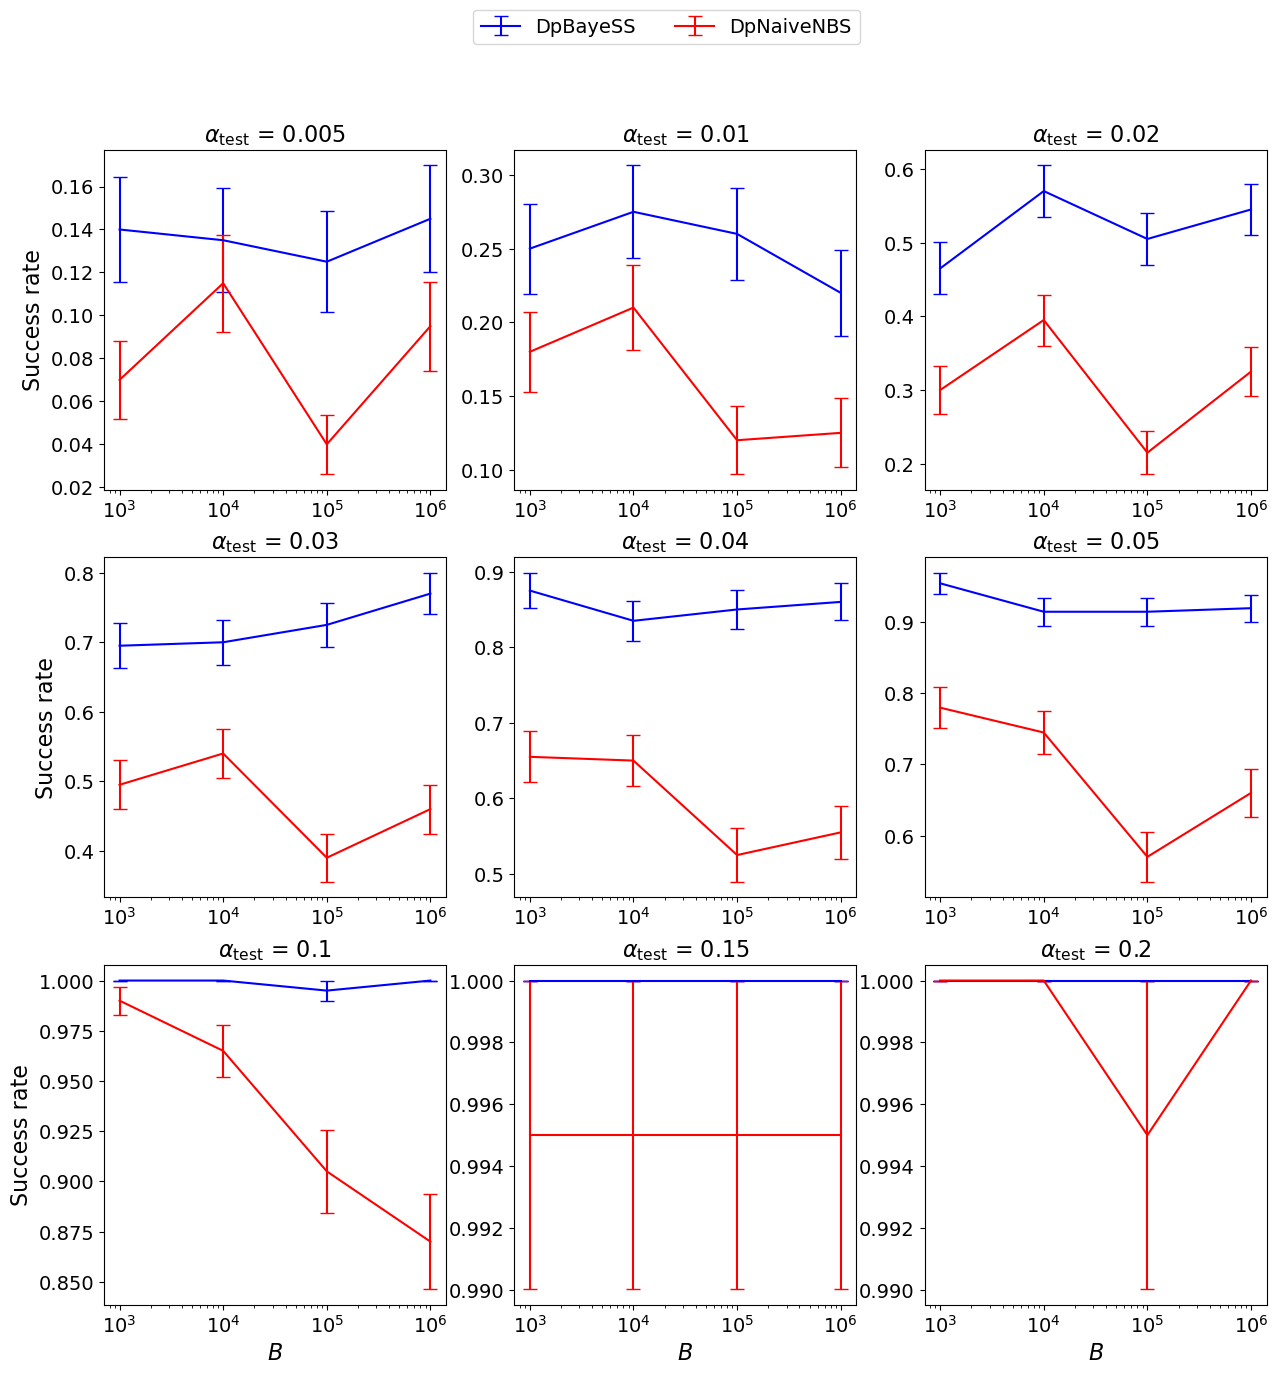

In [180]:
import tqdm as tq
def get_success(coin, cf_dict, alpha, target):
    coin = int(coin)
    cf_dict_domain = np.array(list(cf_dict.keys()))
    cf_dict_coin = cf_dict_domain[np.argmin(np.abs(cf_dict_domain - coin))]
    if cf_dict_coin > coin:
        # get index of the coin
        index = np.where(cf_dict_domain == cf_dict_coin)[0][0]
        coin = cf_dict_domain[index - 1]
    else:
        coin = cf_dict_coin
    if target - alpha < cf_dict[coin] < target + alpha:
        success = True
    else:
        success = False
    return int(success)



fig, axs = plt.subplots(3, 3, figsize=(15, 15))
alpha_test_list = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2]

for fig_index, alpha_test in enumerate(alpha_test_list):
    ax = axs[fig_index // 3, fig_index % 3]  
    # go through the two mechanism
    for i, coins in enumerate(coins_list):
        success = np.zeros((len(num_bins_list)-1, len(coins[0])))
        for j in range(1, len(num_bins_list)):
            data = upload_data(N=N, B=num_bins_list[j])
            for c, coin in enumerate(coins[j]):
                success[j-1, c] = get_success(coin, data["cf_dict"], alpha_test, data["median_quantile"])
        ax.errorbar(num_bins_list[1:],
                    np.mean(success, axis=1),
                    yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]),
                    fmt=markers[i],
                    label=label_list[i],
                    color=colors[i],
                    capsize=5)
    if fig_index // 3 == 2:
        ax.set_xlabel(r"$B$", fontsize=16)
    if fig_index % 3 == 0:
        ax.set_ylabel("Success rate", fontsize=16)
    ax.set_title(r"$\alpha_{\text{test}}$ = " + str(alpha_test), fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14) 
    ax.set_xscale('log')

# make unique legend on top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3, fontsize=14)

# save figure
if not os.path.exists(f"figures"):
    os.makedirs(f"figures")
plt.savefig(f"figures/success_rate_vs_B_N_{N}_eps_{eps}.png", bbox_inches='tight')

plt.show()

# Selected Plots

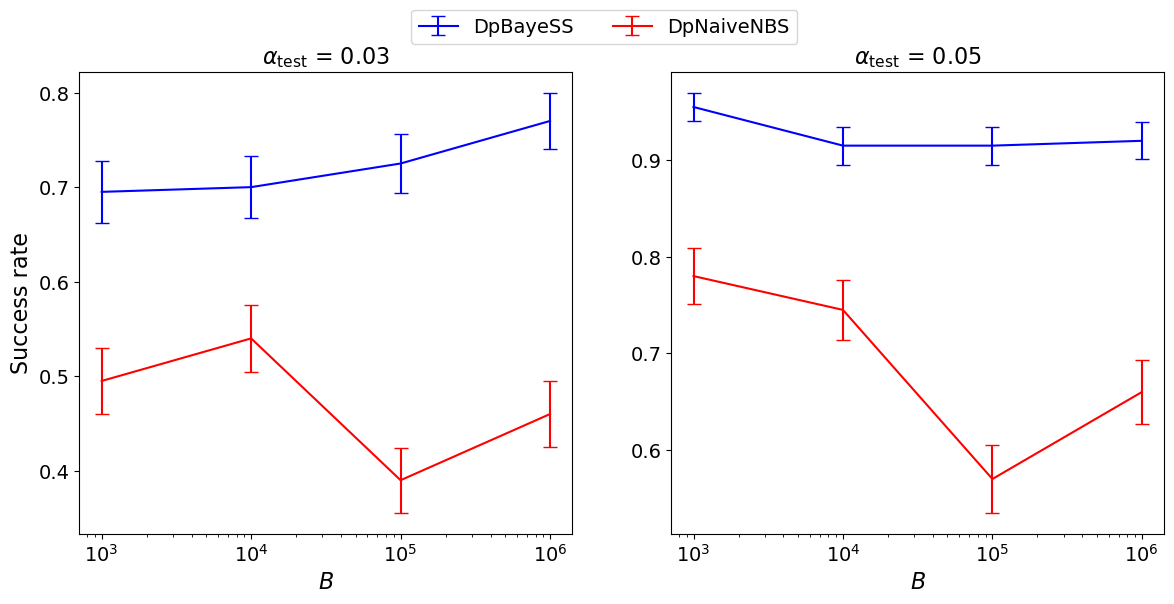

In [181]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
alpha_test_list = [0.03, 0.05]

for fig_index, alpha_test in enumerate(alpha_test_list):
    ax = axs[fig_index]  
    # go through the two mechanism
    for i, coins in enumerate(coins_list):
        success = np.zeros((len(num_bins_list)-1, len(coins[0])))
        for j in range(1,len(num_bins_list)):
            data = upload_data(N=N, B=num_bins_list[j])
            for c, coin in enumerate(coins[j]):
                success[j-1, c] = get_success(coin, data["cf_dict"], alpha_test, data["median_quantile"])
        ax.errorbar(num_bins_list[1:],
                    np.mean(success, axis=1),
                    yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]),
                    fmt=markers[i],
                    label=label_list[i],
                    color=colors[i],
                    capsize=5)
    ax.set_xlabel(r"$B$", fontsize=16)
    if fig_index  == 0:
        ax.set_ylabel("Success rate", fontsize=16)
    ax.set_title(r"$\alpha_{\text{test}}$ = " + str(alpha_test), fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14) 
    ax.set_xscale('log')

# make unique legend on top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=14)

# save figure
folder_name = "selected_plots"
if not os.path.exists(f"figures/{folder_name}"):
    os.makedirs(f"figures/{folder_name}")
plt.savefig(f"figures/{folder_name}/success_rate_vs_B_N_{N}_eps_{eps}.png", bbox_inches='tight')

plt.show()

# CDF for absolute error

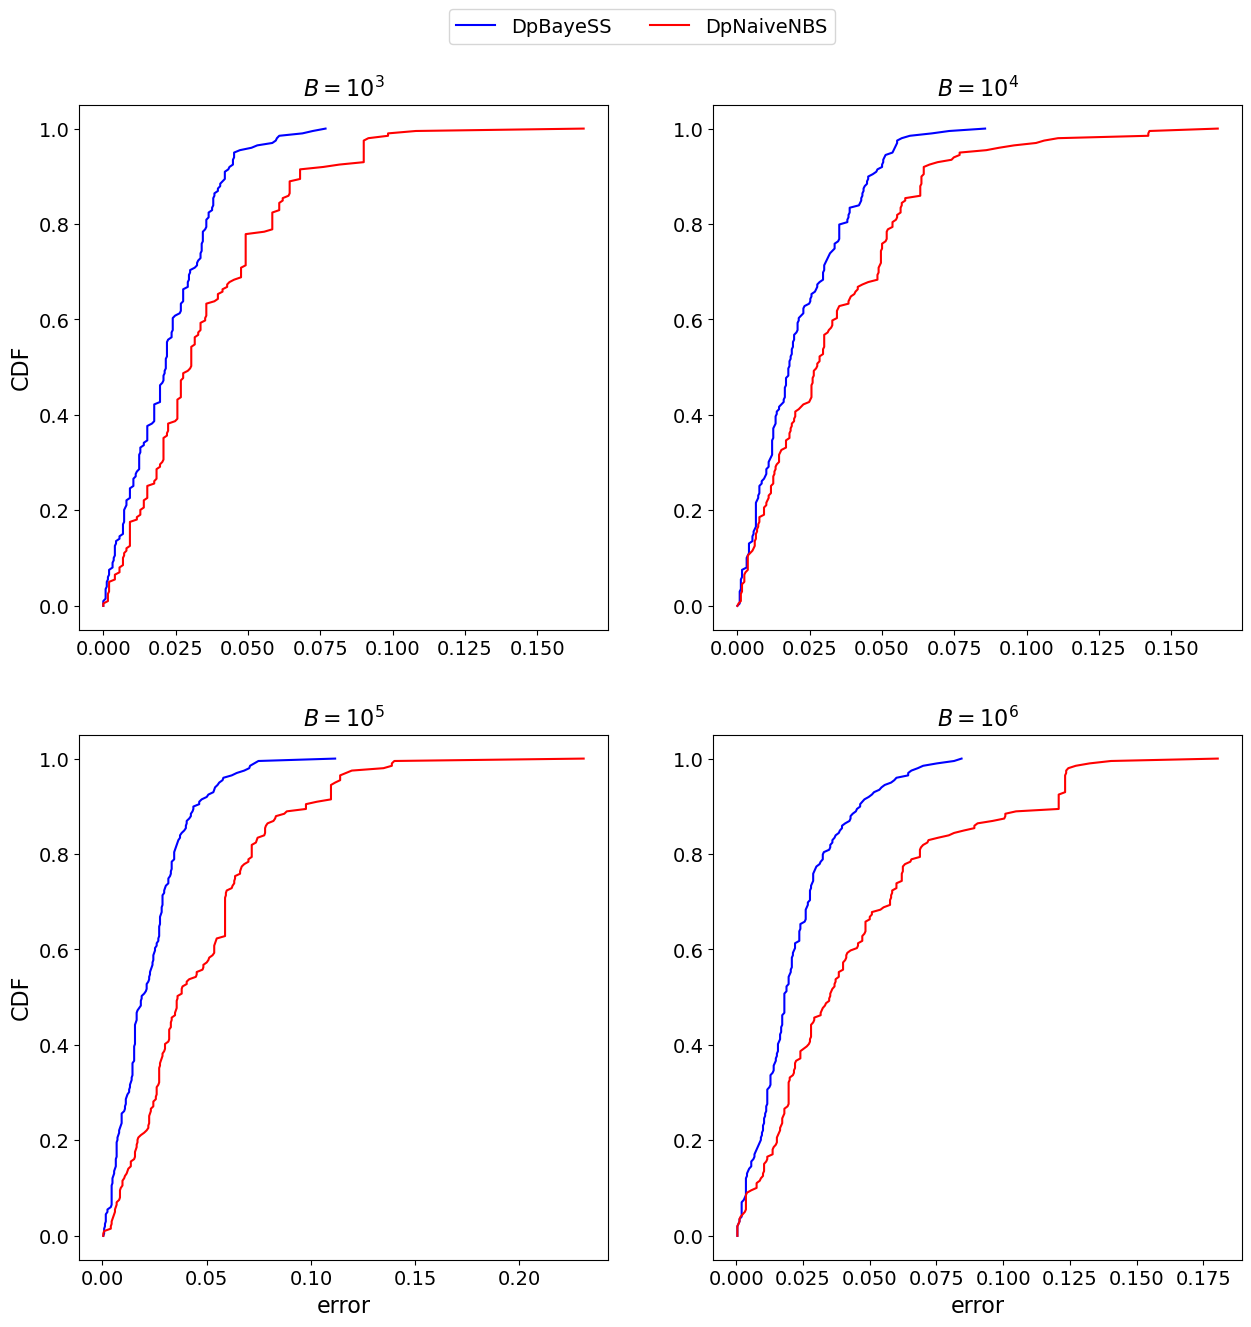

In [182]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
for i, B in enumerate(num_bins_list[1:]):
    ax = axs[i // 2, i % 2]  # Access subplot correctly
    for j in range(2):
        errors = np.abs(errors_list[j])
        errors = np.sort(errors[i+1])
        errors = errors[::-1]
        ax.plot(errors, np.linspace(1, 0, len(errors)), label=label_list[j], color=colors[j], ls=markers[j])
    if i // 2 == 1:
        ax.set_xlabel('error', fontsize=16)
    if i % 2 == 0:
        ax.set_ylabel('CDF', fontsize=16)
    ax.set_title(fr"$B = 10^{int(math.log10(B))}$", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

# add legend on top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=14)

# save figure
if not os.path.exists(f"figures"):
    os.makedirs(f"figures")
plt.savefig(f"figures/abs_cdf_N_{N}_eps_{eps}.png")

plt.show()

# Selected plots

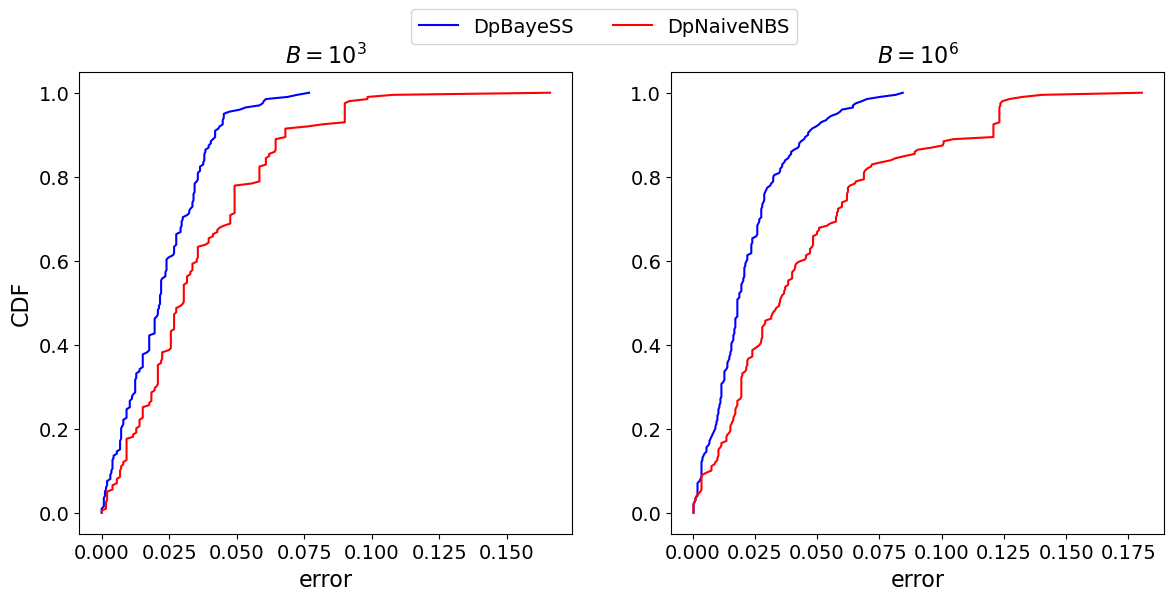

In [183]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
bin_list_index = [1, 4]

for i, B_index in enumerate(bin_list_index):
    ax = axs[i]  # Access subplot correctly
    for j in range(2):
        errors = np.abs(errors_list[j])
        errors = np.sort(errors[B_index])
        errors = errors[::-1]
        ax.plot(errors, np.linspace(1, 0, len(errors)), label=label_list[j], color=colors[j], ls=markers[j])
    if i // 2 == 0:
        ax.set_xlabel('error', fontsize=16)
    if i % 2 == 0:
        ax.set_ylabel('CDF', fontsize=16)
    B = num_bins_list[B_index]
    ax.set_title(fr"$B = 10^{int(math.log10(B))}$", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

# add legend on top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=14)

# save figure
folder_name = "selected_plots"
if not os.path.exists(f"figures/{folder_name}"):
    os.makedirs(f"figures/{folder_name}")
plt.savefig(f"figures/{folder_name}/abs_cdf_N_{N}_eps_{eps}.png", bbox_inches='tight')

plt.show()

# Main Plot

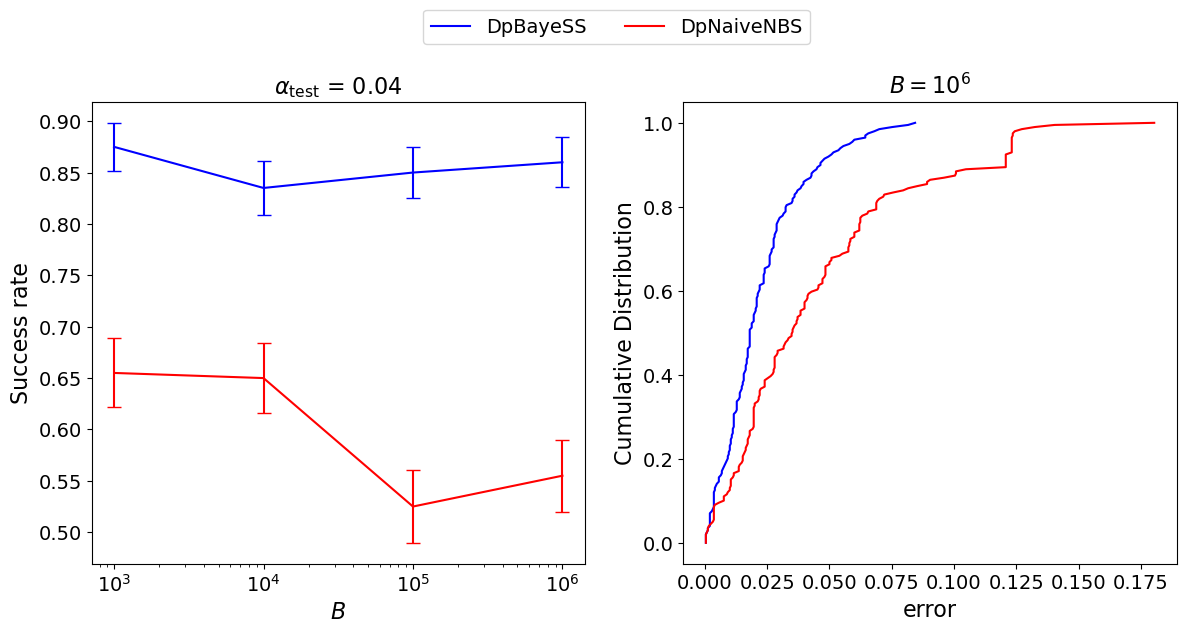

In [184]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
alpha_test_list = [0.04]

for fig_index, alpha_test in enumerate(alpha_test_list):
    ax = axs[fig_index]  
    # go through the two mechanism
    for i, coins in enumerate(coins_list):
        success = np.zeros((len(num_bins_list)-1, len(coins[0])))
        for j in range(1,len(num_bins_list)):
            data = upload_data(N=N, B=num_bins_list[j])
            for c, coin in enumerate(coins[j]):
                success[j-1, c] = get_success(coin, data["cf_dict"], alpha_test, data["median_quantile"])
        ax.errorbar(num_bins_list[1:],
                    np.mean(success, axis=1),
                    yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]),
                    fmt=markers[i],
                    label=label_list[i],
                    color=colors[i],
                    capsize=5)
    ax.set_xlabel(r"$B$", fontsize=16)
    if fig_index  == 0:
        ax.set_ylabel("Success rate", fontsize=16)
    ax.set_title(r"$\alpha_{\text{test}}$ = " + str(alpha_test), fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14) 
    ax.set_xscale('log')
    
bin_list_index = [4]

for i, B_index in enumerate(bin_list_index):
    ax = axs[i+1]  # Access subplot correctly
    for j in range(2):
        errors = np.abs(errors_list[j])
        errors = np.sort(errors[B_index])
        errors = errors[::-1]
        ax.plot(errors, np.linspace(1, 0, len(errors)), label=label_list[j], color=colors[j], ls=markers[j])
    ax.set_xlabel('error', fontsize=16)
    ax.set_ylabel('Cumulative Distribution', fontsize=16)
    B = num_bins_list[B_index]
    ax.set_title(fr"$B = 10^{int(math.log10(B))}$", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

# add legend on top
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=14)

# save figure
folder_name = "main"
if not os.path.exists(f"figures/{folder_name}"):
    os.makedirs(f"figures/{folder_name}")
plt.savefig(f"figures/{folder_name}/main_{N}_eps_{eps}.png", bbox_inches='tight')

plt.show()